In [1]:
# !pip install ../pyldpc

In [2]:
import numpy as np
import pandas as pd
import hashlib
import random
import sys
sys.path.append("../")
# from python_fuzzy_extractor.fuzzy_extractor import FuzzyExtractor
from python_fuzzy_extractor.fuzzy_extractor_LDPC import FuzzyExtractorLDPC as FuzzyExtractor
from entropy import Entropy
import tqdm
from joblib import Parallel, delayed
import multiprocessing
import pickle

from multiprocessing import Pool
import time
# from fuzzy_extractor import FuzzyExtractor


In [3]:
# paramters
# enroll
total_length = 16 # length of input of fuzzy extractor
#The number of bits that can be flipped in the source value and 
# still produce the same key with probability (1 - rep_err).
error_precision = 8
top_score = 16# factor of 16
blocks = int(top_score / total_length)
using_max_entropy_or_random_perm = True
perm_feat = False# use perm for each user?

# prepare dataset

In [4]:
embeddings = np.loadtxt('integerhashingcodes_embeddings_FVC2002_DB1_A_8x512.csv', dtype='int', delimiter=',')#512, binary

In [5]:
extractor = FuzzyExtractor(total_length, error_precision)

# For each user, generate mask from first 3 samples

In [6]:
mess_len = embeddings.shape[1]
masks=[]
for i in tqdm.tqdm(range(100)):
    samples = embeddings[i*5:i*5+3,:]
    entropy_scores = []
    for i in range(mess_len):
        entropy_scores.append(Entropy(samples[:,i]))
    entropy_scores_sort_idx = np.argsort(entropy_scores)
    if using_max_entropy_or_random_perm:
        remain_idx =np.array(entropy_scores_sort_idx, dtype=np.uint8)
    else:
        remain_idx =np.random.permutation(range(512))# if randomly generate index?
    masks.append(remain_idx)

100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


# what if we add some permutation? User-specific?

In [7]:
perms=[]
for i in tqdm.tqdm(range(100)):
    perms.append(np.random.permutation(range(top_score)))


100%|██████████| 100/100 [00:00<00:00, 48793.67it/s]


# 4th samples as enrollment template, 5 as testing

In [8]:
def randomExclude(n):
    while True:
        tmp = np.random.randint(0, 100, size=1)[0]
        if tmp!=n:
            break
    return tmp

flg=1# debug,one element 


def sub_enroll(i):
    keys= []
    helpers = []
    samples = embeddings[i*5+3,:]
    mask = masks[i][:top_score]
    samples_masked = samples[mask]
    # perm the hash codes
    if perm_feat:
        samples_masked = samples_masked[perms[i]]
    for starti in range(blocks):
        s = samples_masked[starti*total_length:(starti+1)*total_length]
        # fuzzy extractor
        key, helper = extractor.generate(s)
        keys.append(key)
        helpers.append(helper)
    return keys,helpers



In [9]:
# enroll
pool = Pool(processes = 12)
start_time=time.perf_counter()
results = []
for i in range(100):
    # 维持执行的进程总数为processes，当一个进程执行完毕后会添加新的进程进去
    r1 = pool.apply_async(sub_enroll, args=(i, ))    
    results.append(r1)
print('======  apply_async  ======')
pool.close()
#调用join之前，先调用close函数，否则会出错。执行完close后不会有新的进程加入到pool,join函数等待所有子进程结束
pool.join()


keys= []
helpers = []
    
for i in range(100):
    ikeys,ihelpers = results[i].get(timeout=100)
    keys.append(ikeys)
    helpers.append(ihelpers)

end_time=time.perf_counter()
    
print(f"Total time of Thread execution {round(end_time- start_time,4)} for the function ")


======  apply_async  ======
Total time of Thread execution 113.4623 for the function 


# Query and test

In [10]:
np.savez('masks.npy',masks)
np.savez('keys.npy',keys)
np.savez('embeddings.npy',embeddings)

In [11]:
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename

def load_variavle(filename):
   f=open(filename,'rb')
   r=pickle.load(f)
   f.close()
   return r

# filename = save_variable(helpers,'helpers.txt')
# results = load_variavle('helpers.txt')
#################################
def sub_repro_imposter(i):
    j = randomExclude(i)# imposter, random one
    samples = embeddings[j*5+4,:]## using imposter biometric data
    mask = masks[j][:top_score]
    samples_masked = samples[mask]
    key = keys[i]
    helper = helpers[i]
    # perm the hash codes
    if perm_feat:
        samples_masked = samples_masked[perms[i]]
    positive_num=0
    for starti in range(blocks):
        p = samples_masked[starti*total_length:(starti+1)*total_length]
        # fuzzy extractor reproduce
        r_key = extractor.reproduce(p, helper[starti])  # r_key will probably still equal key!
        if r_key and r_key==key[starti]:
            positive_num = positive_num+1
    return positive_num

def sub_repro_imposter_disclosure_mask(i):
    j = randomExclude(i)# imposter, random one
    samples = embeddings[j*5+4,:]## using imposter biometric data
    mask = masks[i][:top_score]
    samples_masked = samples[mask]
    key = keys[i]
    helper = helpers[i]
    # perm the hash codes
    if perm_feat:
        samples_masked = samples_masked[perms[j]]
    positive_num=0
    for starti in range(blocks):
        p = samples_masked[starti*total_length:(starti+1)*total_length]
        # fuzzy extractor reproduce
        r_key = extractor.reproduce(p, helper[starti])  # r_key will probably still equal key!
        if r_key and r_key==key[starti]:
            positive_num = positive_num+1
    return positive_num


def sub_repro_genuine(i):
    samples = embeddings[i*5+4,:]
    mask = masks[i][:top_score]
    samples_masked = samples[mask]
    key = keys[i]
    helper = helpers[i]

    # perm the hash codes
#     samples_masked = samples_masked[perms[i]]
    if perm_feat:
        samples_masked = samples_masked[perms[i]]
    positive_num=0
    for starti in range(blocks):        
        p = samples_masked[starti*total_length:(starti+1)*total_length]
        # fuzzy extractor reproduce
        r_key = extractor.reproduce(p, helper[starti])  # r_key will probably still equal key!
#         print('***********************************************')
#         print('++++',r_key,key[starti],'******',starti)
        if r_key and r_key==key[starti]:
            positive_num = positive_num+1
#         if r_key == None:
#             continue
#         elif abs(np.subtract(r_key, key[starti])).sum() == 0:#r_key==key[starti]
#             positive_num = positive_num+1
# #     print('process',i,positive_num)
    return positive_num

In [12]:
# query
#lets try 7th with mated
positive_nums=[]

pool = Pool(processes = 12)
start_time=time.perf_counter()
results = []
for i in range(100):
    # 维持执行的进程总数为processes，当一个进程执行完毕后会添加新的进程进去
    r1 = pool.apply_async(sub_repro_genuine, args=(i, ))    
    results.append(r1)
print('======  apply_async  ======')
pool.close()
#调用join之前，先调用close函数，否则会出错。执行完close后不会有新的进程加入到pool,join函数等待所有子进程结束
pool.join()


for i in range(100):
    positive_nums.append(results[i].get(timeout=100))

end_time=time.perf_counter()
    
print(f"Total time of Thread execution {round(end_time- start_time,4)} for the function ")
# print(positive_nums)


======  apply_async  ======


/home/charles/miniconda3/lib/python3.8/site-packages/pyldpc/decoder.py:62: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  warnings.warn("""Decoding stopped before convergence. You may want
/home/charles/miniconda3/lib/python3.8/site-packages/pyldpc/decoder.py:62: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  warnings.warn("""Decoding stopped before convergence. You may want
/home/charles/miniconda3/lib/python3.8/site-packages/pyldpc/decoder.py:62: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  warnings.warn("""Decoding stopped before convergence. You may want
/home/charles/miniconda3/lib/python3.8/site-packages/pyldpc/decoder.py:62: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  warnings.warn("""Decoding stopped before convergence. You may want


Total time of Thread execution 121.5433 for the function 


In [13]:
print(sum(np.array(positive_nums)>0)/len(positive_nums))


0.73


# imposter

## imposter knows 

In [14]:
false_positive_nums = []
pool = Pool(processes = 10)
start_time=time.perf_counter()
results = []
for i in range(100):
    # 维持执行的进程总数为processes，当一个进程执行完毕后会添加新的进程进去
    r1 = pool.apply_async(sub_repro_imposter, args=(i, ))    
    results.append(r1)
print('======  apply_async  ======')
pool.close()
#调用join之前，先调用close函数，否则会出错。执行完close后不会有新的进程加入到pool,join函数等待所有子进程结束
pool.join()


for i in range(100):
    false_positive_nums.append(results[i].get(timeout=100))

end_time=time.perf_counter()
    
print(f"Total time of Thread execution {round(end_time- start_time,4)} for the function ")


======  apply_async  ======


/home/charles/miniconda3/lib/python3.8/site-packages/pyldpc/decoder.py:62: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  warnings.warn("""Decoding stopped before convergence. You may want
/home/charles/miniconda3/lib/python3.8/site-packages/pyldpc/decoder.py:62: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  warnings.warn("""Decoding stopped before convergence. You may want
/home/charles/miniconda3/lib/python3.8/site-packages/pyldpc/decoder.py:62: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  warnings.warn("""Decoding stopped before convergence. You may want
/home/charles/miniconda3/lib/python3.8/site-packages/pyldpc/decoder.py:62: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  warnings.warn("""Decoding stopped before convergence. You may want


Total time of Thread execution 113.8734 for the function 


In [15]:
false_positive_nums_same_mask = []
pool = Pool(processes = 12)
start_time=time.perf_counter()
results = []
for i in range(100):
    # 维持执行的进程总数为processes，当一个进程执行完毕后会添加新的进程进去
    r1 = pool.apply_async(sub_repro_imposter_disclosure_mask, args=(i, ))    
    results.append(r1)
print('======  apply_async  ======')
pool.close()
#调用join之前，先调用close函数，否则会出错。执行完close后不会有新的进程加入到pool,join函数等待所有子进程结束
pool.join()


for i in range(100):
    false_positive_nums_same_mask.append(results[i].get(timeout=100))

end_time=time.perf_counter()
    
print(f"Total time of Thread execution {round(end_time- start_time,4)} for the function ")


======  apply_async  ======


/home/charles/miniconda3/lib/python3.8/site-packages/pyldpc/decoder.py:62: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  warnings.warn("""Decoding stopped before convergence. You may want
/home/charles/miniconda3/lib/python3.8/site-packages/pyldpc/decoder.py:62: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  warnings.warn("""Decoding stopped before convergence. You may want
/home/charles/miniconda3/lib/python3.8/site-packages/pyldpc/decoder.py:62: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  warnings.warn("""Decoding stopped before convergence. You may want
/home/charles/miniconda3/lib/python3.8/site-packages/pyldpc/decoder.py:62: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  warnings.warn("""Decoding stopped before convergence. You may want


Total time of Thread execution 117.813 for the function 


In [16]:
print(positive_nums)
# print(false_positive_nums)
print(false_positive_nums_same_mask)
print(false_positive_nums)
print('blocks',blocks)
# print(false_positive_nums2)
threshold1 = max(false_positive_nums)+1
threshold2 = max(false_positive_nums_same_mask)+1
# threshold = 1
print('threshold1:',threshold1)
print('threshold2:',threshold2)
positive_nums = np.array(positive_nums)
# false_positive_nums = np.array(false_positive_nums)
false_positive_nums = np.array(false_positive_nums)
false_positive_nums_same_mask = np.array(false_positive_nums_same_mask)

## 
tpr = sum(positive_nums>=threshold1)/len(positive_nums)
fpr = sum(false_positive_nums>=threshold1)/len(false_positive_nums)

print('tpr,fpr',tpr,fpr)

## 
tpr = sum(positive_nums>=threshold2)/len(positive_nums)
fpr_same_mask = sum(false_positive_nums_same_mask>=threshold2)/len(false_positive_nums_same_mask)

print('tpr,fpr_samemask',tpr,fpr_same_mask)

[0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
blocks 1
threshold1: 1
threshold2: 1
tpr,fpr 0.73 0.0
tpr,fpr_samemask 0.73 0.0


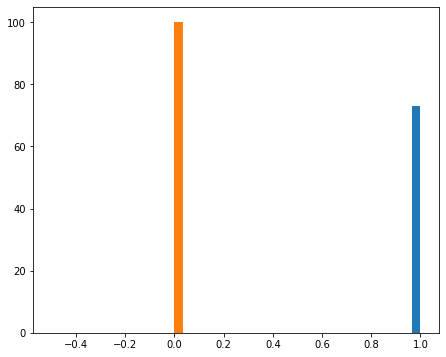

In [17]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,6)) #创建幕布
ax = fig.add_subplot(121) #截取幕布的一部分，121是简写，表示1行2列中的第1个图
ns,edgeBin,patches = plt.hist(positive_nums,bins=30,rwidth=1)
ns,edgeBin,patches = plt.hist(false_positive_nums,bins=30,rwidth=1)


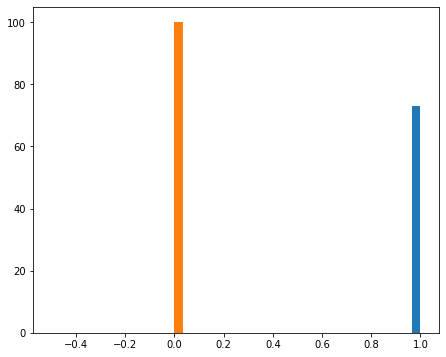

In [18]:
fig = plt.figure(figsize=(16,6)) #创建幕布
ax = fig.add_subplot(121) #截取幕布的一部分，121是简写，表示1行2列中的第1个图
ns,edgeBin,patchesshape = plt.hist(positive_nums,bins=30,rwidth=1)
ns,edgeBin,patches = plt.hist(false_positive_nums_same_mask,bins=30,rwidth=1)


# result 0FAR
